Prashant P. Singh - 8448315

Having made the go with the statistical  model, lets try the deep learning model.

In [1]:
# Lets mount the Google Drive and acccess the data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pickle
path = '/content/drive/MyDrive/IMDB/Filtered_Data'  # path to the folder in google drive where data is saved


When we are using any kind of Emebedding layer either it could be pre-trained or it could be one which we create using the model and corpus derived from our text-collection. In this exercise we will be creating the embedding layer but this layer will be trained along (with other layers). Further the tokenizer we use here uses the corpus (derived from our text), rather than using any predefined one like 'Brown or Universal' of nltk library.

In [2]:
# lets build custom tokenizer adapted for this corpus
# https://www.tensorflow.org/addons/tutorials/networks_seq2seq_nmt
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

import tensorflow as tf
def tokenize(lang, num_words = None):
        # lang = list of sentences in a language

        # lets select the default config and basic Tokenizer from keras
        
        lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<OOV>', num_words= num_words)

        # this step is necessary to allow tokenzier build its words id for the corpus 
        # from the lang = list of sentences
        lang_tokenizer.fit_on_texts(lang)

        ## tf.keras.preprocessing.text.Tokenizer.texts_to_sequences converts string (w1, w2, w3, ......, wn) 
        ## to a list of correspoding integer ids of words (id_w1, id_w2, id_w3, ...., id_wn)
        tensor = lang_tokenizer.texts_to_sequences(lang) 

        ## tf.keras.preprocessing.sequence.pad_sequences takes argument a list of integer id sequences 
        ## and pads the sequences to match the longest sequences in the given input
        # this will make all sentences of same length
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

        return tensor, lang_tokenizer

In [ ]:
# Example to see if this is working fine
sent = ["I am Prashant","I am not Prashant"]
a,b = tokenize(sent)  # a is tensor with ids, b is tokenizer itself
print("token ids of sentence: ",a)
print("tokenizer words index: ",b.word_index)
c = ["I am myself"]
print(b.texts_to_sequences(c))

token ids of sentence:  [[2 3 4 0]
 [2 3 5 4]]
tokenizer words index:  {'<OOV>': 1, 'i': 2, 'am': 3, 'prashant': 4, 'not': 5}
[[2, 3, 1]]


In [ ]:
# Example to see how num_words (maximum number of words to consider acts)
# num_words include 0 (for padding) and 1 (for Out of Vocab), hence we are basically
# allowing only one word to be represented when we set num_words = 3
sent = ["I am Prashant","I am not Prashant"]
a,b = tokenize(sent, num_words = 3)  # a is tensor with ids, b is tokenizer itself
print("token ids of sentence: ",a)
print("tokenizer words index: ",b.word_index)
c = ["I am myself"]
print(b.texts_to_sequences(c))

token ids of sentence:  [[2 1 1 0]
 [2 1 1 1]]
tokenizer words index:  {'<OOV>': 1, 'i': 2, 'am': 3, 'prashant': 4, 'not': 5}
[[2, 1, 1]]


In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# this will return the lang_tokenizer and trianing data set adapted to maxlen and max_features(number of words to consider in vocab)
# why not test? we will be using the lang_tokenizer on test to transform.
def create_data(max_features = 20000, maxlen = 200):
  # max_features = 20000     # Only considering the top 20k words, which can be tuned
  # maxlen = 200          # Only considering the first 200 words of each movie review which can be tuned

  train_text, lang_tokenizer = tokenize(d_train.text, num_words= max_features)
  print("Words corpus is ", len(lang_tokenizer.word_index))

  X_train = lang_tokenizer.texts_to_sequences(d_train.text) 
 
  # reduce all sentences to size of 200, if sentence is less than this size will add padding of zero
  X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen, padding='post')

  return lang_tokenizer, X_train

We will make LSTM stacked model( with and without skip connection). The reason is two folds:
1. LSTM are known for their language modelling (sequential data)
2. If any model can capture the essence of sequence modelling and does the task of predicting what is going to be the next word, sequence then we beleive in essence it is leanring some semantic representations of words. Once this leanring is done then the model can be used for many other task rather than predicting next word in sequence.

Why Stacked LSTM? We know from convolutional neural network the effect of applying filters and  stacking convolutional layers leads to feature representation with lower layer giving basic features and higher one building more complex features. We will implement the stacked LSTM with same spirit that it can learn better semantic for the words and help in better classification.

Why Bi-LSTM: the intuition is simple, when we are reading something, we are not just using past words ,sentence to understand the present sentence/word but at the same time also updating the understandig we might have got about the past. This is what happens in Bi-directional LSTM too. It has both past and future updation capability.

Why skip- connection? We pass the emddding layer output also to the next lstm layer. While the first layer will learn some basic representation, higher lstm layer will use the output of previous lstm and embedding to make more complicated feature representtion

What are embedding layer: Words are just a token or number for the model, however what is important that these words can be represented in some dimension whereby words like King,Father are closer to each other than compared to Queen and mother, and might have same distance as they hold in lingustic. The emebedding layer is just the same trick where words are projected into n-dimensional space and we can hope during the learning such feature represenation occurs (which actually does)  
The regularizing effect will be introduced through dropout and recurrent dropout.

In [ ]:
# https://keras.io/examples/nlp/bidirectional_lstm_imdb/

def bi_lstm(max_features, embedding_size = 128, lstmcell = 64, r_dropout = 0.0, dropout = 0.0): 
  import numpy as np
  from tensorflow import keras
  from tensorflow.keras import layers

  # Input for variable-length sequences of integers
  inputs = keras.Input(shape=(None,), dtype="int32")

  # Embed each integer in a 128-dimensional vector (default), else into embedding_size
  x = layers.Embedding(max_features, output_dim = embedding_size)(inputs)

  #  2 bidirectional LSTMs
  x = layers.Bidirectional(layers.LSTM(lstmcell, return_sequences=True,dropout = dropout, recurrent_dropout = r_dropout))(x)
  x = layers.Bidirectional(layers.LSTM(lstmcell,recurrent_dropout = r_dropout))(x)

  # Add a classifier
  outputs = layers.Dense(1, activation="sigmoid")(x)
  model = keras.Model(inputs = inputs, outputs = outputs)

  # model.summary()
  return "BI_LSTM", model

In [ ]:
# skip connection, we pass the emddding layer output also to the next lstm layer. 
# While the first layer will learn some basic representation, higher lstm layer will use the output of previous lstm and
# embedding to make more complicated feature representtion

def lstm_withskip(max_features, embedding_size = 128, lstmcell = 64, r_dropout = 0.0, dropout = 0.0):
  import numpy as np
  from tensorflow import keras
  from tensorflow.keras import layers

  # Input for variable-length sequences of integers
  inputs = keras.Input(shape=(None,), dtype="int32")

  # Embed each integer in a 128-dimensional vector(default), else into embedding_size
  x = layers.Embedding(max_features, output_dim = embedding_size)(inputs)

  #  2 bidirectional LSTMs
  lstm1 = layers.Bidirectional(layers.LSTM(lstmcell, return_sequences=True, dropout = dropout, recurrent_dropout = r_dropout))(x)

  # implementing skip connection, ( this can be done with Add and concatenate and they both have different impact)
  # https://theaisummer.com/skip-connections/

  x = layers.Add()([lstm1,x])
  x = layers.Bidirectional(layers.LSTM(lstmcell, recurrent_dropout = r_dropout))(x)
  
  # Add a classifier
  outputs = layers.Dense(1, activation="sigmoid")(x)
  model = keras.Model(inputs = inputs, outputs = outputs)
  # model.summary()
  return "BI_LSTM_withSkip", model

In [ ]:
def get_models():
    random_state = 7
    models=dict()

    name, model = bi_lstm(max_features= max_features)
    models[name] = model

    name, model = lstm_withskip(max_features= max_features)
    models[name] = model

    return models

In [ ]:
def display_history(history,name ="None"):

    import seaborn as sns
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np                                        
    # notebook and use it by doing slight modification
    # """Summarize history for accuracy and loss.

    sns.set_palette("pastel")
    sns.set(style="darkgrid")
    path = '/content/drive/MyDrive/IMDB/'

    fig, ax = plt.subplots(figsize=(10,6),sharey='row')
    title = "Loss_for_{}".format(name)
    sns.lineplot(data=history.history['loss'], ax = ax)
    sns.lineplot(data=history.history['val_loss'], ax = ax)
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.title(title)
    fig.savefig(path + title + '.png')

    fig, ax = plt.subplots(figsize=(10,6),sharey='row')
    title = "Accuracy_for_{}".format(name)
    sns.lineplot(data=history.history['accuracy'], ax = ax)
    sns.lineplot(data=history.history['val_accuracy'], ax = ax)
    ax.set_xlabel('epoch')
    ax.set_ylabel('accuracy')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.title(title)
    fig.savefig( path + title + '.png')


Words corpus is  96044
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 128)         2560000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2,757,761
Trainable para

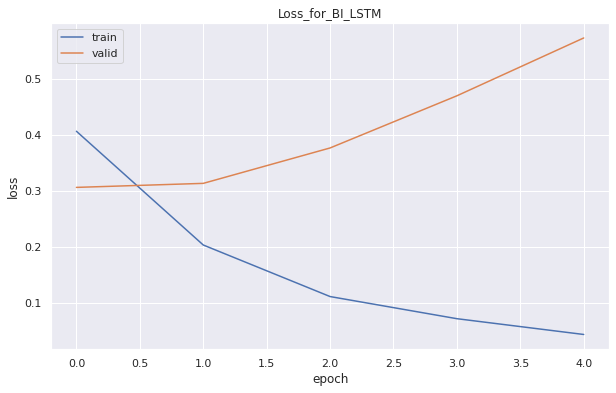

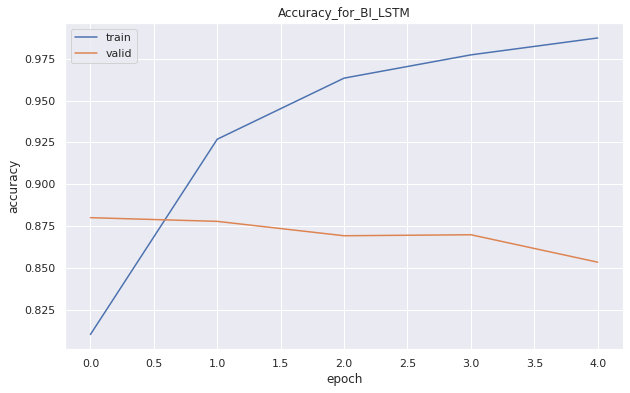

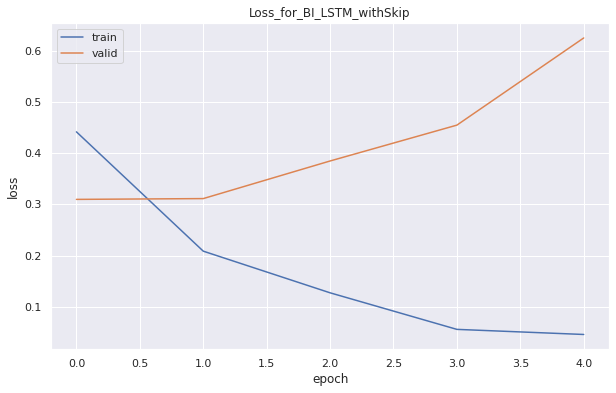

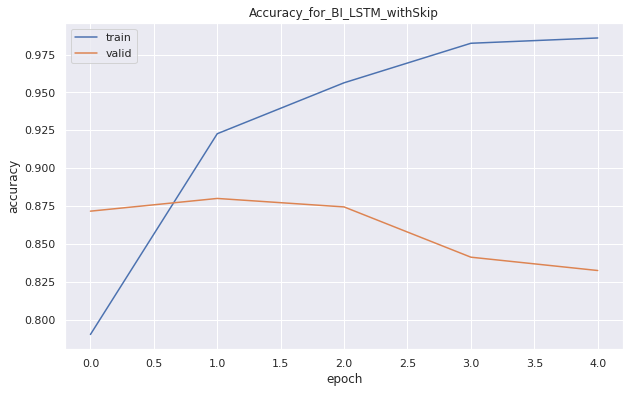

In [ ]:
from numpy.random import seed
import tensorflow as tf
from tensorflow.keras import backend as be
from sklearn.metrics import accuracy_score
import pandas as pd 
from sklearn.model_selection import train_test_split

# clear the session and reset the tensorflow graph
be.clear_session()
tf.compat.v1.reset_default_graph()

# setting the values for max_features (total words count to be considered) and 
# maxlen (of sentences, if less than this padding will be added)

max_features = 20000
maxlen = 200

# setting random seed for reproduction of results
from numpy.random import seed
seed(7)
tf.random.set_seed(7)

batchsize = 64
epoch = 5
lang_tokenizer, X_train = create_data()

# creating train-valid split
X_train, X_val, y_train, y_val = train_test_split(X_train, d_train.label, train_size=0.8, random_state= 7)

# book keeeping
report = pd.DataFrame(columns = ['model','optimizer','batchsize', 'epoch','Val_loss','Valid_accuracy']) 

models = get_models()

for name, model in models.items():
    model.summary()
    model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
    history = model.fit(X_train, y_train, batch_size=batchsize, epochs=epoch, validation_data=(X_val, y_val))
    display_history(history,name)
    print("Evaluating on valid set...")
    (loss, accuracy) = model.evaluate(X_val, y_val)
    print("loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))
    
    # appending to book keeeping dataframe
    report.loc[len(report)] = [name,"Adam",batchsize, epoch,loss, accuracy]




In [ ]:
# DELETE

report.to_csv("LSTM2.csv")
report

,model,optimizer,batchsize,epoch,Val_loss,Valid_accuracy
0,BI_LSTM,Adam,64,5,0.572668,0.8534
1,BI_LSTM_withSkip,Adam,64,5,0.625109,0.8324


#### As can be seen the bidirectional LSTM model gives good accuracy and both format reach the val accuracy level of 88%. Further as we see after 1 epoch model seems to be going into overfitting whereby the trianing and valid start to diverge, therefore we can do some regularization and hypertuning before passing the verdict.

In [ ]:
! pip install tensorflow_addons

# To use the RADAM optimizer
# https://www.tensorflow.org/addons/api_docs/python/tfa/optimizers/RectifiedAdam


     |▎                               | 10 kB 19.3 MB/s eta 0:00:01
     |▋                               | 20 kB 26.3 MB/s eta 0:00:01
     |▉                               | 30 kB 30.0 MB/s eta 0:00:01
     |█▏                              | 40 kB 33.6 MB/s eta 0:00:01
     |█▌                              | 51 kB 19.1 MB/s eta 0:00:01
     |█▊                              | 61 kB 14.2 MB/s eta 0:00:01
     |██                              | 71 kB 12.2 MB/s eta 0:00:01
     |██▍                             | 81 kB 13.5 MB/s eta 0:00:01
     |██▋                             | 92 kB 14.6 MB/s eta 0:00:01
     |███                             | 102 kB 14.8 MB/s eta 0:00:01
     |███▎                            | 112 kB 14.8 MB/s eta 0:00:01
     |███▌                            | 122 kB 14.8 MB/s eta 0:00:01
     |███▉                            | 133 kB 14.8 MB/s eta 0:00:01
     |████▏                           | 143 kB 14.8 MB/s eta 0:00:01
     |████▍                           | 15

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow_addons.optimizers import RectifiedAdam
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras import initializers
import numpy as np

# lets create one combined model (for both skip and without skip connection) with one more Dense layer added in the end
def create_model(optimizer = 'adam', init = 'glorot_uniform', lstm_cell_size = 64,
                dropout_rate_dense = 0.2, embedding_size = 128, max_features = 20000, r_dropout = 0.2, skip = False):
  
  # Input for variable-length sequences of integers

  inputs = keras.Input(shape=(None,), dtype="int32")

  # Embed each integer in a 128-dimensional vector
  x = layers.Embedding(max_features, embedding_size)(inputs)

  #  2 bidirectional LSTMs
  lstm1 = layers.Bidirectional(layers.LSTM(lstm_cell_size, return_sequences=True, dropout = 0.1,
                                       kernel_initializer = init, recurrent_dropout = r_dropout,
                                       recurrent_initializer = init))(x)
  if skip == False:
      x = layers.Bidirectional(layers.LSTM(lstm_cell_size, dropout = 0.1,
                                        kernel_initializer = init,recurrent_dropout = r_dropout,
                                       recurrent_initializer = init))(lstm1)
  else:

      # we will be using the concatenation instead of Add, as 'Add' will need padding in 
      # embedding layer because of dimension mismatch. (between embedding and Bi-LSTM layer)

      x = layers.Concatenate()([lstm1,x])
      x = layers.Bidirectional(layers.LSTM(lstm_cell_size, dropout = 0.1,
                                        kernel_initializer = init,recurrent_dropout = r_dropout,
                                       recurrent_initializer = init))(x)
  x = layers.Dropout(0.1)(x)

  x = layers.Dense(50, activation="relu")(x)

  # dropout layer
  x = layers.Dropout(dropout_rate_dense)(x)

  # final prediction  
  outputs = layers.Dense(1, activation="sigmoid")(x)

  model = keras.Model(inputs = inputs, outputs = outputs)

  # model.summary()
  return model

In [ ]:
create_model(skip= True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 128)    2560000     ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, None, 128)    98816       ['embedding[0][0]']              
                                                                                                  
 concatenate (Concatenate)      (None, None, 256)    0           ['bidirectional[0][0]',          
                                                                  'embedding[0][0]']          

We will be doing some paramater tuning on the models above, however as the runnig this is computationally expensive we will do it in step-wise manner
Further we are going to use the RADAM, which apart from properties of Adam taken into factor the warm-up aspect (https://arxiv.org/pdf/1908.03265.pdf)


In [ ]:
####

lang_tokenizer, X_train = create_data()

# reducing the train_size to 50% to make runtime faster
X_train, X_val, y_train, y_val = train_test_split(X_train, d_train.label, train_size=0.5, random_state= 7)

# We have tried above the default 'Adam' optimizer, rather we will be using RADAM here.
# keeping the warm-up proportion as 0.1, i.e out of the total steps warm-up will happen for 0.1 steps 
# where it start from zero and goes to lr value during the warm-up phase.

optimizers = [RectifiedAdam(learning_rate = 0.001, warmup_proportion = 0.1, beta_1 = 0.9)]

# kernel initializer types, the difference in both of them is in terms of stddev,
# for glorotnormal : stddev = sqrt(2 / (fan_in + fan_out)) where fan_in is the number of input units 
# in the weight tensor and fan_out is the number of output units in the weight tensor.
# https://www.tensorflow.org/api_docs/python/tf/keras/initializers/GlorotNormal

# for Randomnormal we can use different values but stddev = 0.5 seemed to have worked better(from personal experience)
init = [initializers.GlorotNormal(), initializers.RandomNormal(stddev=0.5)]   
epochs = [2]
batches = [64]
lstm_cell_size = [128]

# recurrent layer dropout
r_dropout = [0.1, 0.3]

# dense layer dropout rate
dropout_rate_dense = [0.1, 0.3, 0.5]
embedding_size = [128]
param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, init=init,lstm_cell_size = lstm_cell_size,
                  dropout_rate_dense = dropout_rate_dense, r_dropout = r_dropout,
                  embedding_size = embedding_size)
model = KerasClassifier(build_fn=create_model, verbose=1)

# instead of trying all 12 combinations we try only 8

grid = RandomizedSearchCV(estimator=model,n_iter= 8, param_distributions=param_grid, cv=2, verbose=3)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Words corpus is  96044


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.


Fitting 2 folds for each of 8 candidates, totalling 16 fits
Epoch 1/2
59/59 [==============================] - 256s 4s/step - loss: nan - accuracy: 0.5040
Epoch 2/2
59/59 [==============================] - 32s 525ms/step - loss: nan - accuracy: 0.5011
[CV 1/2] END batch_size=64, dropout_rate_dense=0.3, embedding_size=128, epochs=2, init=<keras.initializers.initializers_v2.RandomNormal object at 0x7f905cd32210>, lstm_cell_size=128, optimizer=<tensorflow_addons.optimizers.rectified_adam.RectifiedAdam object at 0x7f90517886d0>, r_dropout=0.3;, score=0.501 total time= 8.8min
Epoch 1/2
59/59 [==============================] - 254s 4s/step - loss: nan - accuracy: 0.5048
Epoch 2/2
59/59 [==============================] - 32s 527ms/step - loss: nan - accuracy: 0.4992
[CV 2/2] END batch_size=64, dropout_rate_dense=0.3, embedding_size=128, epochs=2, init=<keras.initializers.initializers_v2.RandomNormal object at 0x7f905cd32210>, lstm_cell_size=128, optimizer=<tensorflow_addons.optimizers.rectifi

Best: 0.718933 using {'r_dropout': 0.3, 'optimizer': <tensorflow_addons.optimizers.rectified_adam.RectifiedAdam object at 0x7f90517886d0>, 'lstm_cell_size': 128, 'init': <keras.initializers.initializers_v2.GlorotNormal object at 0x7f9052bcaf90>, 'epochs': 2, 'embedding_size': 128, 'dropout_rate_dense': 0.1, 'batch_size': 64}

In [ ]:
# now we will explore on vocab size and maxlen
# words corpus is ~ 96000, but as this contains movie names, actor etc therefore we can substantially reduce the size
# also for computation reason we need to restrict this.

num_features = [20000, 30000, 40000]

# usual sentences length is around 200 therefore keeping 100 for lower and 200 as upperbound.
maxlen = [100, 200]

In [ ]:
# finding best combination of max_features and maxlen
for i in num_features:
  for j in maxlen:
    lang_tokenizer, X_train = create_data(max_features=i, maxlen= j)
    X_train, X_val, y_train, y_val = train_test_split(X_train, d_train.label, train_size=0.5, random_state= 7)
    model = create_model(optimizer = RectifiedAdam(learning_rate = 0.001, warmup_proportion = 0.1, beta_1 = 0.9),
                         init =  initializers.GlorotNormal(), lstm_cell_size = 128, embedding_size = 128, max_features = i,
                         dropout_rate_dense = 0.1, r_dropout = 0.3)
    print("max_feat_{}_maxlen{}".format(i,j))
    history = model.fit(X_train, y_train, batch_size=64, epochs= 3, validation_data=(X_val, y_val))
    # display_history(history,'max_feat_{}_maxlen{}'.format)
    print("Evaluating on valid set...")
    (loss, accuracy) = model.evaluate(X_val, y_val)
    print("loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))
                         


Words corpus is  96044
max_feat_20000_maxlen100
Epoch 1/3
196/196 [==============================] - 444s 2s/step - loss: 0.6142 - accuracy: 0.6276 - val_loss: 0.4249 - val_accuracy: 0.8076
Epoch 2/3
196/196 [==============================] - 432s 2s/step - loss: 0.3808 - accuracy: 0.8318 - val_loss: 0.3704 - val_accuracy: 0.8364
Epoch 3/3
196/196 [==============================] - 432s 2s/step - loss: 0.3161 - accuracy: 0.8686 - val_loss: 0.3873 - val_accuracy: 0.8222
Evaluating on valid set...
391/391 [==============================] - 71s 182ms/step - loss: 0.3873 - accuracy: 0.8222
loss=0.3873, accuracy: 82.2240%
Words corpus is  96044
max_feat_20000_maxlen200
Epoch 1/3
196/196 [==============================] - 852s 4s/step - loss: 0.6250 - accuracy: 0.6146 - val_loss: 0.4243 - val_accuracy: 0.8119
Epoch 2/3
196/196 [==============================] - 855s 4s/step - loss: 0.3596 - accuracy: 0.8478 - val_loss: 0.4559 - val_accuracy: 0.8486
Epoch 3/3
196/196 [========================

As can be seen from output the best combination seems to be max_feat_40000_maxlen200, which are both the max values we gave in the search, but lets not increase the computational complexity and keep the values as max_features = 40000, maxlen = 200. Now we will be doing sometuning for batch_size, embedding_size and lstm_cell_size. ( We will be using some of these parameters later in other models, therefore better to explore them now )

In [ ]:
# now the batchsize, embedding size and lstmcell_size
# we are doing this exhaustive so that we can use these in later analysis of using Glove, Fasttext etc


lang_tokenizer, X_train = create_data(max_features= 40000, maxlen= 200)
X_train, X_val, y_train, y_val = train_test_split(X_train, d_train.label, train_size=0.5, random_state= 7)


init = [initializers.GlorotNormal()]   
epochs = [3]
batches = [32, 64]
lstm_cell_size = [64, 128]
r_dropout = [0.3]
dropout_rate_dense = [0.1]
embedding_size = [64,128,256]
max_features = [40000]

optimizers = [RectifiedAdam(learning_rate = 0.001, warmup_proportion = 0.1, beta_1 = 0.9, total_steps= 1000, min_lr= 0.00005)]
param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, init=init,lstm_cell_size = lstm_cell_size,
                  dropout_rate_dense = dropout_rate_dense, r_dropout = r_dropout,max_features = max_features,
                  embedding_size = embedding_size)
model = KerasClassifier(build_fn=create_model, verbose=1)

# instead of trying all 12 combinations we will run only 8 combinations

grid = RandomizedSearchCV(estimator=model,n_iter= 8, param_distributions=param_grid, cv=2, verbose=3)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Words corpus is  96044


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.


Fitting 2 folds for each of 8 candidates, totalling 16 fits
Epoch 1/3
98/98 [==============================] - 246s 2s/step - loss: 0.6930 - accuracy: 0.5054
Epoch 2/3
98/98 [==============================] - 238s 2s/step - loss: 0.6011 - accuracy: 0.6782
Epoch 3/3
98/98 [==============================] - 27s 263ms/step - loss: 0.4457 - accuracy: 0.7976
[CV 1/2] END batch_size=64, dropout_rate_dense=0.1, embedding_size=256, epochs=3, init=<keras.initializers.initializers_v2.GlorotNormal object at 0x7f98a21d5050>, lstm_cell_size=64, max_features=40000, optimizer=<tensorflow_addons.optimizers.rectified_adam.RectifiedAdam object at 0x7f98a21d5b10>, r_dropout=0.3;, score=0.798 total time=13.1min
Epoch 1/3
98/98 [==============================] - 260s 2s/step - loss: 0.6932 - accuracy: 0.5000
Epoch 2/3
98/98 [==============================] - 248s 3s/step - loss: 0.5922 - accuracy: 0.6798
Epoch 3/3
98/98 [==============================] - 28s 275ms/step - loss: 0.4340 - accuracy: 0.8082
[CV

In [ ]:
import pandas as pd
df = pd.DataFrame(list(zip(means,stds,params)),
               columns =['mean', 'stddev', 'param_config'])
df.to_csv("/content/drive/MyDrive/IMDB/grid_lstm_batch.csv")

#### "Best: 0.842160 using {'r_dropout': 0.3, 'optimizer': <tensorflow_addons.optimizers.rectified_adam.RectifiedAdam object at 0x7f98a21d5b10>, 'max_features': 40000, 'lstm_cell_size': 128, 'init': <keras.initializers.initializers_v2.GlorotNormal object at 0x7f98a21d5050>, 'epochs': 3, 'embedding_size': 128, 'dropout_rate_dense': 0.1, 'batch_size': 32}"

It is pointed that even though accuracy level dropped than compared to previous param search, but we are doing this with fixed number fo epoch, so the drop in accuracy can be ignored for now.

In [ ]:
def get_models():
    random_state = 7
    models=dict()

    name, model = bi_lstm(max_features= max_features, dropout=0.1)
    models[name] = model

    name, model = lstm_withskip(max_features= max_features,dropout=0.1)
    models[name] = model

    return models

###RESULTS FROM GRIDSEARCH:

Best: 0.718933 using {'r_dropout': 0.3, 'optimizer': <tensorflow_addons.optimizers.rectified_adam.RectifiedAdam object at 0x7f90517886d0>, 'lstm_cell_size': 128, 'init': <keras.initializers.initializers_v2.GlorotNormal object at 0x7f9052bcaf90>, 'epochs': 2, 'embedding_size': 128, 'dropout_rate_dense': 0.1, 'batch_size': 64}

max_feat_40000_maxlen200

Best: 0.842160 using {'r_dropout': 0.3, 'optimizer': <tensorflow_addons.optimizers.rectified_adam.RectifiedAdam object at 0x7f98a21d5b10>, 'max_features': 40000, 'lstm_cell_size': 128, 'init': <keras.initializers.initializers_v2.GlorotNormal object at 0x7f98a21d5050>, 'epochs': 3, 'embedding_size': 128, 'dropout_rate_dense': 0.1, 'batch_size': 32}


Words corpus is  96044
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 128)         5120000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        263168    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 50

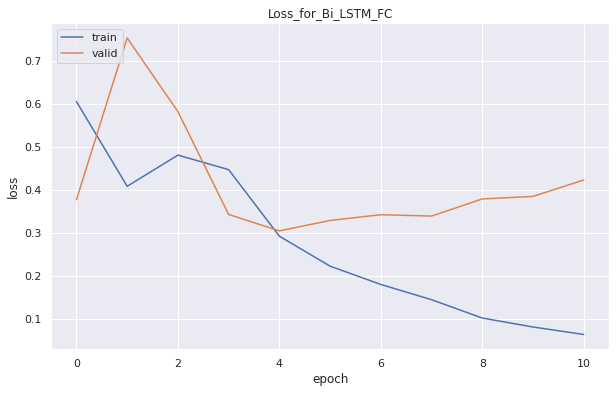

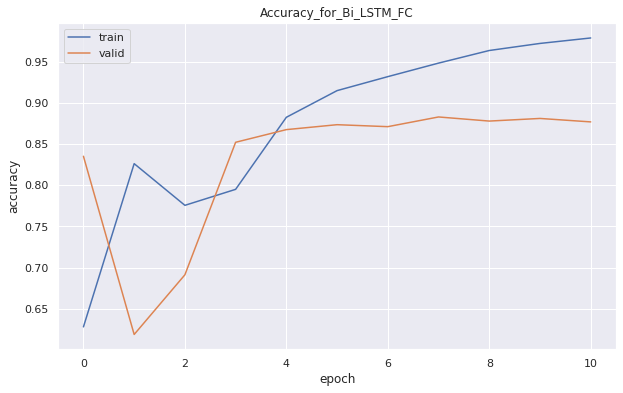

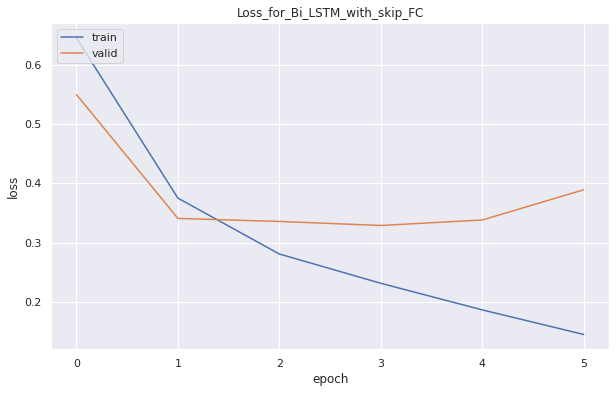

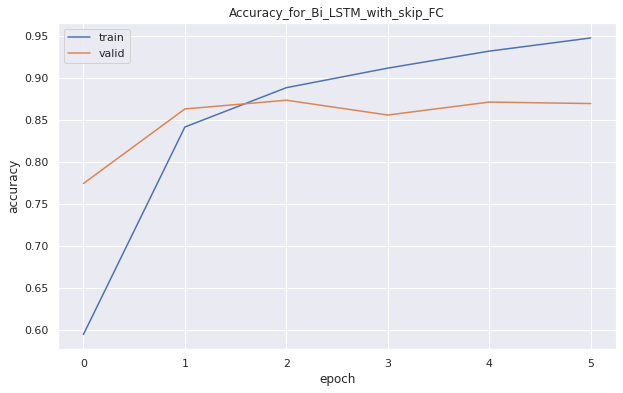

In [ ]:
# so finally we can run the Bi-LSTM with the configuration we have found 
from numpy.random import seed
import tensorflow as tf
from tensorflow.keras import backend as be
from sklearn.metrics import accuracy_score
import pandas as pd 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
be.clear_session()
tf.compat.v1.reset_default_graph()

from numpy.random import seed
seed(7)
tf.random.set_seed(7)

# assigning param values 
max_features = 40000
maxlen = 200
batchsize = 32
epochs = 20

# book keeping
report = pd.DataFrame(columns = ['model','Val_loss','Valid_accuracy', 'Test_Val','Test_accuracy']) 


lang_tokenizer, X_train = create_data(max_features= 40000, maxlen= 200)

# we run now of 80-20 split
X_train, X_val, y_train, y_val = train_test_split(X_train, d_train.label, train_size=0.8, random_state= 7) 

# Tokekizing the test
X_test = lang_tokenizer.texts_to_sequences(d_test.text)

# padding for maxlen, for  train this is done by calling the fucntion as padding is included in 'def tokenize', however for
# appying the same to test we need to call it explicitly.

X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen, padding='post')
y_test = d_test.label

models = {}

# using the models created with addition of one Dense layer before final prediction
models['Bi_LSTM_FC'] = create_model(optimizer=RectifiedAdam(learning_rate = 0.001, warmup_proportion = 0.1, beta_1 = 0.9, total_steps= 10000, min_lr= 0.0005),
                                    lstm_cell_size = 128, embedding_size = 128, init = initializers.GlorotNormal(),max_features = max_features,
                                    r_dropout = 0.3, dropout_rate_dense = 0.1, skip = False)
# models['Bi_LSTM_FC'] = model_fc
models['Bi_LSTM_with_skip_FC'] = create_model(optimizer=RectifiedAdam(learning_rate = 0.001, warmup_proportion = 0.1, beta_1 = 0.9, total_steps= 10000, min_lr= 0.0005),
                                              lstm_cell_size = 64, embedding_size = 128, init = initializers.GlorotNormal(), max_features = max_features,
                                              r_dropout = 0.3, dropout_rate_dense = 0.1, skip = True)


# param for early stopping, number of epoch to wait before terminating the process, if no improvmenet seen for the monitored quantity
patience = 3 

for name, model in models.items():
    model.summary()
    model.compile(RectifiedAdam(learning_rate = 0.001, warmup_proportion = 0.1, beta_1 = 0.9, total_steps= 10000, min_lr= 0.0005), 
                  "binary_crossentropy", metrics=["accuracy"])

    # will be used in callback to stop the training process if no improvment seen. We can keep the monitored quantity as val_loss, however here we
    # are using val_accuracy as that is the metric on which we are benchmarking the models
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=patience,
                                                   mode='max', restore_best_weights = False)
                            
    history = model.fit(X_train, y_train, batch_size=batchsize, epochs=epochs, validation_data=(X_val, y_val), callbacks = [early_stopping], 
                       verbose = 1)
                       
    display_history(history,name)
    print("Evaluating on valid set...{}".format(name))
    (val_loss, val_accuracy) = model.evaluate(X_val, y_val)
    print("loss={:.4f}, accuracy: {:.4f}%".format(val_loss,val_accuracy * 100))
    print("Evaluating on test set...{}".format(name))
    (test_loss, test_accuracy) = model.evaluate(X_test, y_test)
    print("loss={:.4f}, accuracy: {:.4f}%".format(test_loss,test_accuracy * 100))
    report.loc[len(report)] = [name,val_loss, val_accuracy, test_loss, test_accuracy]



In [ ]:
report.to_csv('/content/drive/MyDrive/IMDB/lstm.csv')
report

,model,Val_loss,Valid_accuracy,Test_Val,Test_accuracy
0,Bi_LSTM_FC,0.423844,0.8772,0.457326,0.86608
1,Bi_LSTM_with_skip_FC,0.389068,0.8696,0.425093,0.86176


Using the max_featutres = 40000 and maxlen= 200, we make one final run on the models without the Dense and further the skip connection is implemented through Add ( rather than concatenation above)

Words corpus is  96044
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         5120000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 5,317,761
Trainable params: 5,317,761
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
625/625 [==============================] - 39s 52ms/step - loss: 0.5986 - accuracy:

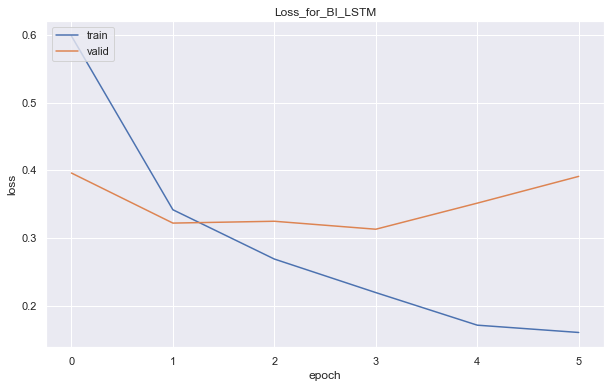

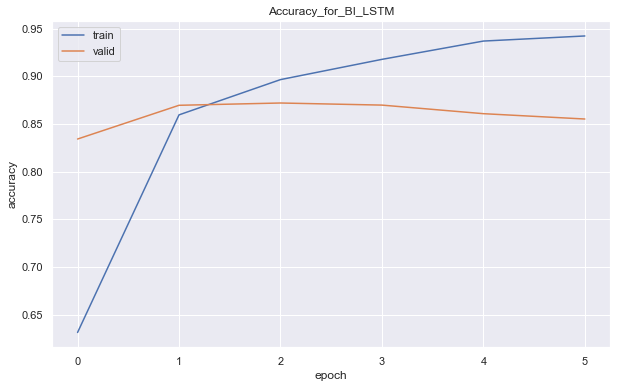

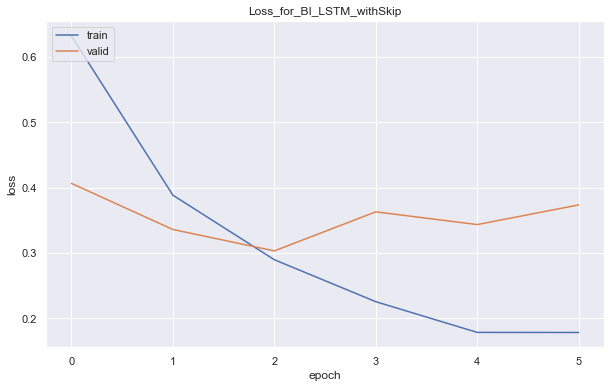

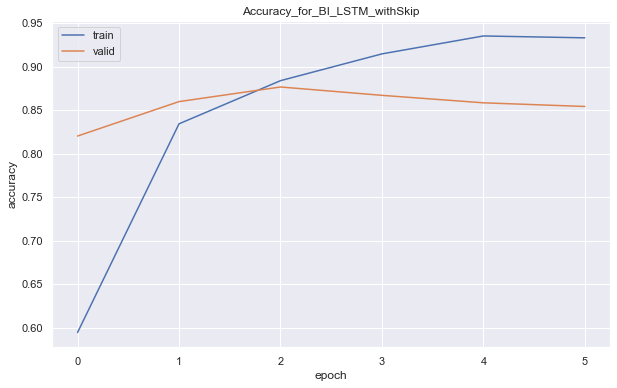

In [ ]:
# so finally we can run the Bi-LSTM with the configuration we have found 
from numpy.random import seed
import tensorflow as tf
from tensorflow.keras import backend as be
from sklearn.metrics import accuracy_score
import pandas as pd 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
be.clear_session()
tf.compat.v1.reset_default_graph()
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow_addons.optimizers import RectifiedAdam
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras import initializers
import numpy as np

from numpy.random import seed
seed(7)
tf.random.set_seed(7)

max_features = 40000
maxlen = 200
batchsize = 32
epochs = 20

report = pd.DataFrame(columns = ['model','Val_loss','Valid_accuracy', 'Test_Val','Test_accuracy']) 


lang_tokenizer, X_train = create_data(max_features= 40000, maxlen= 200)
X_train, X_val, y_train, y_val = train_test_split(X_train, d_train.label, train_size=0.8, random_state= 7) 

# padding for maxlen, for  train this is done by calling the fucntion as padding is included in 'def tokenize', however for
# appying the same to test we need to call it explicitly.
X_test = lang_tokenizer.texts_to_sequences(d_test.text)
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen, padding='post')
y_test = d_test.label

models = get_models()

# param for early stopping, number of epoch to wait before terminating the process, if no improvmenet seen for the monitored quantity
patience = 3

for name, model in models.items():
    model.summary()
    model.compile(RectifiedAdam(learning_rate = 0.001, warmup_proportion = 0.1, beta_1 = 0.9, total_steps= 10000, min_lr= 0.0005), 
                  "binary_crossentropy", metrics=["accuracy"])

    # Early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=patience,
                                                   mode='max', restore_best_weights = False)

    history = model.fit(X_train, y_train, batch_size=batchsize, epochs=epochs, validation_data=(X_val, y_val),  callbacks = [early_stopping], 
                       verbose = 1)
    display_history(history,name)
    print("Evaluating on valid set...{}".format(name))
    (val_loss, val_accuracy) = model.evaluate(X_val, y_val)
    print("loss={:.4f}, accuracy: {:.4f}%".format(val_loss,val_accuracy * 100))
    print("Evaluating on test set...{}".format(name))
    (test_loss, test_accuracy) = model.evaluate(X_test, y_test)
    print("loss={:.4f}, accuracy: {:.4f}%".format(test_loss,test_accuracy * 100))
    report.loc[len(report)] = [name,val_loss, val_accuracy, test_loss, test_accuracy]



In [ ]:
report.to_csv('LSTM1.csv')
report

,model,Val_loss,Valid_accuracy,Test_Val,Test_accuracy
0,BI_LSTM,0.324746,0.8720,0.336666,0.86360
1,BI_LSTM_withSkip,0.303370,0.8766,0.315858,0.86612


In [18]:
# read the csv files and then make the plot of Valid vs Test.
import pandas as pd 
df1 = pd.read_csv(path+'LSTM1.csv')
df2 = pd.read_csv(path + 'lstm.csv')
df = pd.concat([df1,df2])

In [19]:
df = df[['model','Valid_accuracy','Test_accuracy']]
df[['Valid_accuracy','Test_accuracy']]  = df[['Valid_accuracy','Test_accuracy']].round(decimals = 3)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = float(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = float(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

def model_plot(df):
   
  # some fancy thing to make plots nice, you can different palette types and style
  # https://seaborn.pydata.org/tutorial/color_palettes.html
  
  sns.set_palette("pastel")
  sns.set(style="darkgrid")
  fig, ax = plt.subplots( figsize=(20,6))
  a = sns.barplot(data=df, x="model", y= 'Accuracy Score', hue="Type", ax = ax)
  a.set_title('Accuracy Score for Models')
  show_values_on_bars(a, "v", 0.5)
  fig.savefig(path + "Finalplot_LSTM_model"+ '.png')

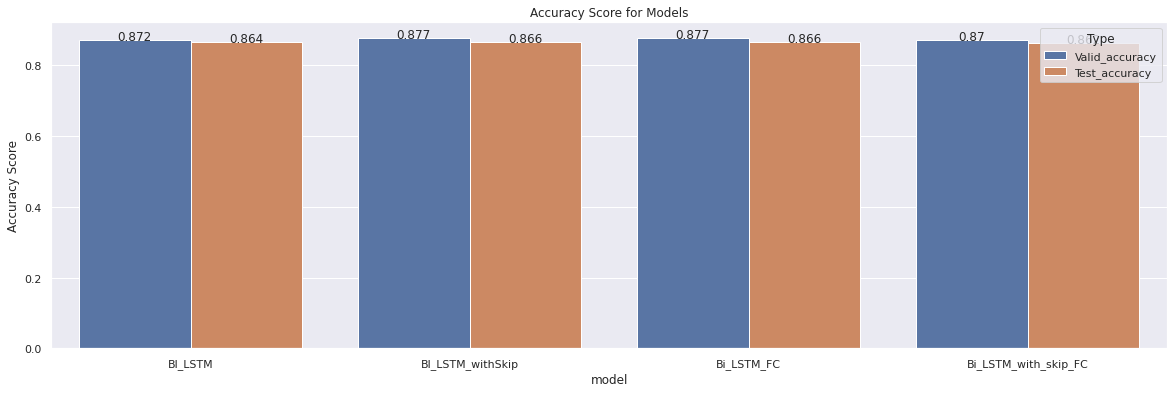

In [20]:
# Reshaping dataframe in  way to make it compatible to pass it to seaborn
df = pd.melt(df, id_vars=["model"], var_name="Type", value_name="Accuracy Score")
model_plot(df)

All the models almost reach the same test accuracy, however are tailing behind the statistical model. However this doesnt means that the model are bad, remember the statistical models are building this non-linear relationship between features and target but it is more of coorelation in nature, rather than higher level semantic or representational learning. In this respect the model are good enough but can be further improved by combining with the CNN. Further scope of improvmeent can come from n-grams > 1, we are using only unigrams here. This could be another scope of improvement.

As mentioned we are making our own embedding, but what if we can use the embeddings trained on huge corpus which are good at giving better represenation to words. Further it is important to understand what characteristic we are using for creating this embedding (next to follow is glove). Lets move onto next notebook to use pre-trained embeddings for  further improvement.

Disadvantages: computational expensive, large possibility of network architecture (this is also good thing, but not always) and hence lot of need for fine tuning. If we make network more deeper vanishing gradient problem can also creep in. Overfititng one easy thing for deep leanring models and need be properly tamed with.

Takeways: Its better to start with simple Deep learning model (not too deep not too wide) and benchmark the whatever metric we are using and then go ahead to further fine tune and use them with better intermediate layers  (Pretrianed embedding, convolutional layers etc)

https://keras.io/api/callbacks/early_stopping/